In [9]:
#!/.conda/envs/learn python
# -*- coding: utf-8 -*-

"""
多类别精度评定

预测结果和真值标签均为栅格
文件名相同，尺寸相同，不需要地理坐标系
~~~~~~~~~~~~~~~~
code by wHy
Aerospace Information Research Institute, Chinese Academy of Sciences
wanghaoyu191@mails.ucas.ac.cn
"""

'\n多类别精度评定\n\n预测结果和真值标签均为栅格\n文件名相同，尺寸相同，不需要地理坐标系\n~~~~~~~~~~~~~~~~\ncode by wHy\nAerospace Information Research Institute, Chinese Academy of Sciences\nwanghaoyu191@mails.ucas.ac.cn\n'

In [10]:
import os
from statistics import mean
import sys
import fnmatch
import numpy as np
import gdal
import ogr
import osr
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [11]:
os.environ['GDAL_DATA'] = r'C:\Users\75198\.conda\envs\learn\Lib\site-packages\GDAL-2.4.1-py3.6-win-amd64.egg-info\gata-data' #防止报error4错误

ground_truth_path = r'E:\xinjiang_huyang_hongliu\Huyang_test_0808\1-raster_label\1-raster_label_haze_lv1' # 存储真值标签的文件夹 真值标签应为栅格 带有地理坐标系
predict_path = r'D:\github_repository\ChaIR\Dehazing\OTS\results\ChaIR\test\LV1\predict_result' # 存储预测栅格的文件 带有地理坐标系

'''为了省事自动检索预测结果文件夹下的tif影像'''
pre_pic_name = fnmatch.filter(os.listdir(predict_path), '*.tif')
pre_pic_name_full = predict_path + '/' + pre_pic_name[0][:-4] + '.tif'

im_data_pre_full = []
im_data_true_full = []
listpic = fnmatch.filter(os.listdir(ground_truth_path), '*.tif')
for gt_name in listpic:
    gt_full_path = ground_truth_path + '/' + gt_name[:-4] + '.tif'
    pre_pic_name_full = predict_path + '/' + gt_name[:-4] + '_result.tif'
    '''以真值标签为参考，从预测栅格文件中裁剪出待评定部分'''
    # 获取真值标签地理坐标信息
    input_gt = gdal.Open(gt_full_path)

    # 获取预测结果数据
    input_pre = gdal.Open(pre_pic_name_full)

    # 定义裁剪窗口大小
    win_size = input_gt.RasterXSize

    # 整理数据
    im_data_pre = input_pre.ReadAsArray(0, 0, win_size, win_size)  # 读取预测结果对应区域的数据
    im_data_true = input_gt.ReadAsArray(0, 0, win_size, win_size) # 读取真值标签区域数据

    print(im_data_pre.shape, im_data_true.shape)
    print(type(im_data_pre))

    im_data_pre = list(im_data_pre.reshape(-1)) # 展平为一维
    im_data_true = list(im_data_true.reshape(-1)) # 展平为一维

    im_data_pre_full = im_data_pre_full + im_data_pre # 链接
    im_data_true_full = im_data_true_full + im_data_true

    
unique_pre, count_pre=np.unique(im_data_pre_full,return_counts=True)
data_count_pre=dict(zip(unique_pre, count_pre))
unique_true,count_true=np.unique(im_data_true_full,return_counts=True)
data_count_true=dict(zip(unique_true,count_true))
print(data_count_pre)
print(data_count_true)



(512, 512) (512, 512)
<class 'numpy.ndarray'>
(512, 512) (512, 512)
<class 'numpy.ndarray'>
(512, 512) (512, 512)
<class 'numpy.ndarray'>
{0: 690584, 1: 84414, 2: 11434}
{0: 696959, 1: 63452, 2: 26021}


Confusion matrix:
[[0.9780891  0.01970561 0.00220529]
 [0.08570258 0.89869508 0.01560235]
 [0.13289266 0.52480689 0.34230045]] 

Accuracy: 0.9300117492675781
Balanced Accuracy: 0.7579125940775936
My Balanced Accuracy: 0.7396948749093551
Precision: 0.8062044719484205
Recall: 0.7579125940775936
F1 Score: 0.7122714768289162


              precision    recall  f1-score   support

  background       0.99      0.97      0.98    228865
     populus       0.49      0.95      0.64     15701
  red_willow       0.94      0.35      0.51     17578

    accuracy                           0.93    262144
   macro avg       0.81      0.76      0.71    262144
weighted avg       0.96      0.93      0.93    262144



<Figure size 432x288 with 0 Axes>

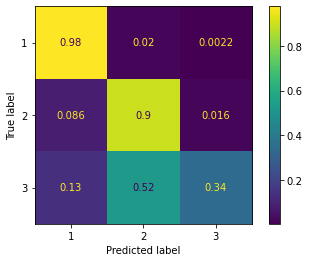

In [12]:
'''精度评定部分'''
'''计算混淆矩阵'''
cm = confusion_matrix(im_data_true_full, im_data_pre_full, normalize='true')
print("Confusion matrix:")
print(cm, '\n')
accuracy = accuracy_score(im_data_true, im_data_pre)
balanced_accuracy = balanced_accuracy_score(im_data_true, im_data_pre)
precision = precision_score(im_data_true, im_data_pre, average='macro', zero_division=0) # 'macro' 表示对所有类别的精确率求平均值
recall = recall_score(im_data_true, im_data_pre, average='macro', zero_division=0) # 'macro' 表示对所有类别的召回率求平均值
f1 = f1_score(im_data_true, im_data_pre, average='macro', zero_division=0)  # 'macro' 表示对所有类别的 F1 分数求平均值

# 输出综合精度指标
print('Accuracy:', accuracy)
print('Balanced Accuracy:', balanced_accuracy)
balanced_accuracy = (cm[0][0]+ cm[1][1] + cm[2][2])/3
print('My Balanced Accuracy:', balanced_accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('\n')

# 生成分类报告
report = classification_report(im_data_true, im_data_pre, target_names=['background', 'populus', 'red_willow'])
print(report)

# 画出混淆矩阵
# ConfusionMatrixDisplay 需要的参数: confusion_matrix(混淆矩阵), display_labels(标签名称列表)
labels = {'1', '2', '3'}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
plt.clf()